Build a regression model.

In [17]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import shapiro
import matplotlib.pyplot as plt

In [318]:
EDA_df = pd.read_csv('../data/EDA_data.csv')

As noted in the section on EDA, the variables in this dataset do not show any discernible inherent linear relationship. 

In [319]:
EDA_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3356 entries, 0 to 3355
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   free_bikes            3356 non-null   int64  
 1   latitude              3356 non-null   float64
 2   longitude             3356 non-null   float64
 3   poi_distance          3356 non-null   float64
 4   poi_source            3356 non-null   object 
 5   poi_rating            3356 non-null   float64
 6   poi_price_level       3356 non-null   float64
 7   poi_total_reviews     3356 non-null   float64
 8   poi_primary_category  3356 non-null   object 
 9   poi_sub_category      3356 non-null   object 
dtypes: float64(6), int64(1), object(3)
memory usage: 262.3+ KB


In [329]:
formula1 = 'poi_rating ~ free_bikes + latitude + longitude + poi_distance + poi_price_level + poi_total_reviews + C(poi_primary_category) + C(poi_source)'

In [330]:
model = smf.ols(formula=formula1, data=EDA_df).fit()

In [ ]:
# R-squared Adj. Rsquared Dependent Variables No. Independent Variables
# 0.164       0.088         poi_rating           all other columns
# 0.013       0.010         poi_rating            ''               except poi_sub_category

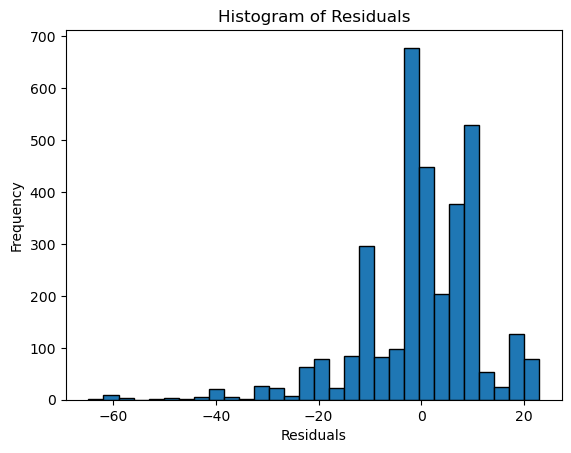

In [332]:
plt.hist(model.resid, bins=30, edgecolor='k')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

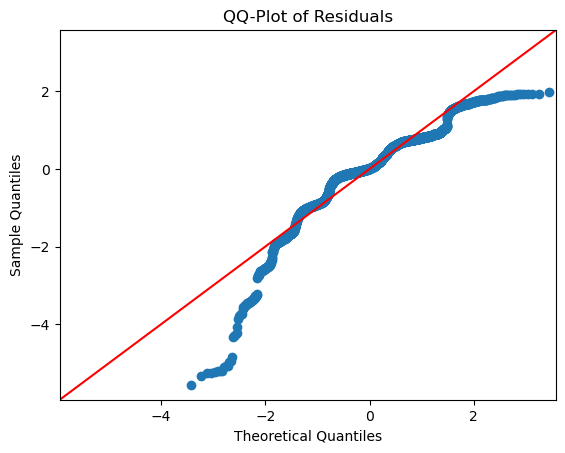

In [333]:
sm.qqplot(model.resid, line='45', fit=True)
plt.title('QQ-Plot of Residuals')
plt.show()

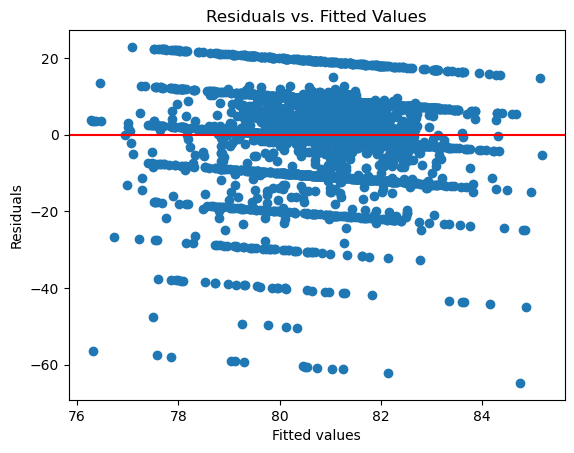

In [334]:
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

In [326]:
# hypothesis test for normality. alpha = 0.05
stat, p = shapiro(model.resid)

In [327]:
p

1.598329885512012e-34

Provide model output and an interpretation of the results. 

In [335]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             poi_rating   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     4.882
Date:                Mon, 23 Oct 2023   Prob (F-statistic):           1.60e-06
Time:                        09:29:15   Log-Likelihood:                -12999.
No. Observations:                3356   AIC:                         2.602e+04
Df Residuals:                    3346   BIC:                         2.608e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     1.9889    309.912      0.006      0.995    -605.648     609.626
C(poi_primary_category)[T.Fashion Retail]     1.3795      1.529      0.902      0.367      -1.619       4.378
C(poi_primary_category)[T.Restaurant]        -0.3413      0.602     -0.567      0.571      -1.522       0.839
C(poi_source)[T.yelp]                         0.5609      0.463      1.210      0.226      -0.348       1.469
free_bikes                                    0.1191      0.094      1.272      0.203      -0.064       0.303
latitude                                      4.8676      5.798      0.840      0.401      -6.500      16.235
longitude                                   -13.0628      2.422     -5.394      0.000     -17.811      -8.314
poi_distance                               9.157e-05      0.001      0.147      0.883      -0.001       0.001
poi_price_level                              -1.2195      0.341     -3.576      0.000      -1.888      -0.551
poi_total_reviews                             0.0029      0.003      0.931      0.352      -0.003       0.009
==============================================================================
Omnibus:                      875.958   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2936.353
Skew:                          -1.293   Prob(JB):                         0.00
Kurtosis:                       6.783   Cond. No.                     9.27e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The designed model has poor predictive power, reflected by the low Adj. R-squared of 0.01. Using all the features available or a subset of them does not seem to improve the predictive power. This strongly suggests that either linear regression is a poor model for the underlying relationship or the collected data is not representative enough to fully represent the relationships. The following are the observations from the tests done to validate the fitted model:
1. The residuals of the model violate the normality assumptions of the OLS regression, as captured by the histogram plot and the hypothesis test for normality.
2. The QQ-plot of the residuals seem to suggest strong influence of the outliers
3. From the plot of the residuals vs fitted values, the variance of the residuals do not seem randomly scattered around the horizontal line at zero, showing a clear violation of homoscedasticity.

An effort will be made to improve the model in the following ways:
1. The numeric values will be normalized to address conditioning errors and other numerical issues
2. The outliers will be removed
3. The independent variables will be pruned to only those with statistically significant coefficients

In [348]:
# Redo model design.
EDA_df = pd.read_csv('../data/EDA_data.csv')
# Remove outliers
EDA_df = EDA_df.loc[(EDA_df['free_bikes']<=5)&(EDA_df['poi_rating']>=60)&(EDA_df['poi_price_level']<=3)&(EDA_df['poi_total_reviews']<=150),:]
# Normalize numerical values
numeric_cols=EDA_df.select_dtypes(include=['number']).columns
EDA_df[numeric_cols] = (EDA_df[numeric_cols] - EDA_df[numeric_cols].min()) / (EDA_df[numeric_cols].max() - EDA_df[numeric_cols].min())
# Prune independent variables
formula = 'poi_rating ~  poi_price_level + poi_total_reviews + C(poi_primary_category) + C(poi_source)'

In [349]:
model = smf.ols(formula=formula, data=EDA_df).fit()

In [350]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             poi_rating   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     18.43
Date:                Mon, 23 Oct 2023   Prob (F-statistic):           4.67e-18
Time:                        09:56:44   Log-Likelihood:                 138.17
No. Observations:                2894   AIC:                            -264.3
Df Residuals:                    2888   BIC:                            -228.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     0.5708      0.013     42.484      0.000       0.544       0.597
C(poi_primary_category)[T.Fashion Retail]     0.1034      0.033      3.094      0.002       0.038       0.169
C(poi_primary_category)[T.Restaurant]        -0.0273      0.013     -2.118      0.034      -0.053      -0.002
C(poi_source)[T.yelp]                         0.0659      0.010      6.699      0.000       0.047       0.085
poi_price_level                              -0.0585      0.016     -3.770      0.000      -0.089      -0.028
poi_total_reviews                            -0.0889      0.020     -4.381      0.000      -0.129      -0.049
==============================================================================
Omnibus:                       92.108   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.564
Skew:                          -0.457   Prob(JB):                     1.45e-22
Kurtosis:                       3.016   Cond. No.                         12.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

After the corrective steps, the predictive power of the model is still poor. This again strongly suggests that either linear regression is a poor model for the underlying relationship or the collected data is not representative enough to fully embed the relationships. From the tests below, we can at least say that the assumptions for using a linear regression model are not met.

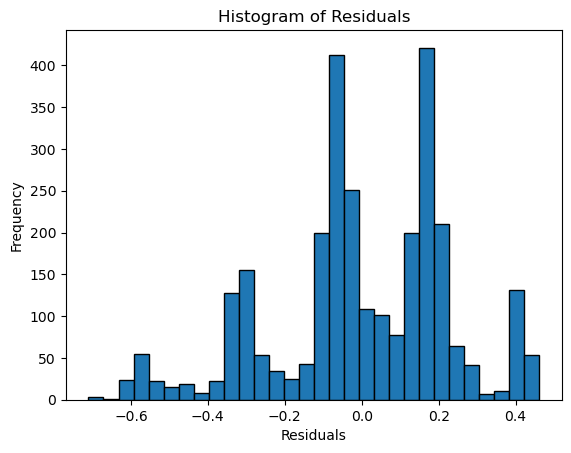

In [351]:
plt.hist(model.resid, bins=30, edgecolor='k')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

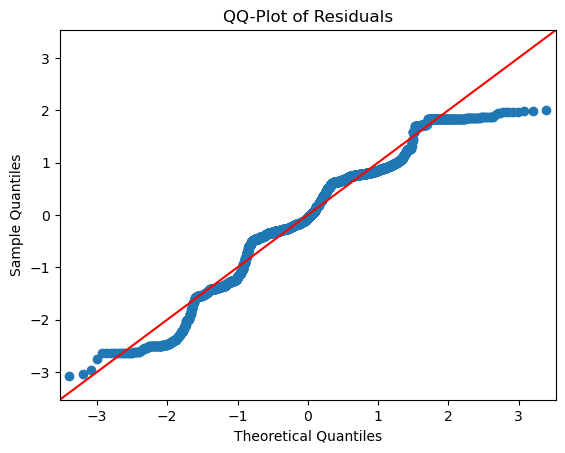

In [352]:
sm.qqplot(model.resid, line='45', fit=True)
plt.title('QQ-Plot of Residuals')
plt.show()

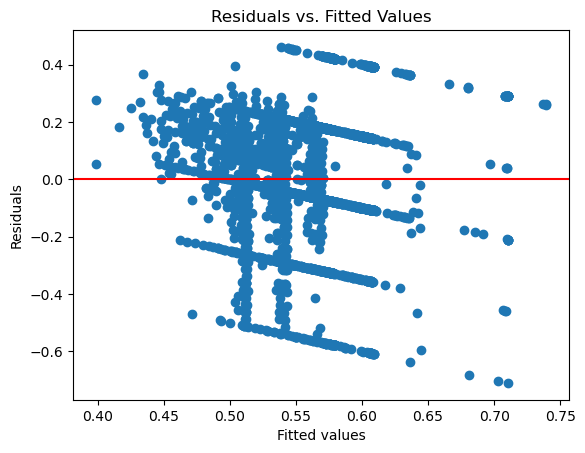

In [353]:
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

In [354]:
# hypothesis test for normality. alpha = 0.05
stat, p = shapiro(model.resid)
p

3.852198544295893e-26

# Stretch

How can you turn the regression model into a classification model?

In this section, an effort will be made to predict the ratings using multinomial regression classification

In [355]:
# model design.
EDA_df = pd.read_csv('../data/EDA_data.csv')
# Remove outliers
EDA_df = EDA_df.loc[(EDA_df['free_bikes']<=5)&(EDA_df['poi_rating']>=60)&(EDA_df['poi_price_level']<=3)&(EDA_df['poi_total_reviews']<=150),:]
# Normalize numerical values
numeric_cols=EDA_df.select_dtypes(include=['number']).columns
EDA_df[numeric_cols] = (EDA_df[numeric_cols] - EDA_df[numeric_cols].min()) / (EDA_df[numeric_cols].max() - EDA_df[numeric_cols].min())

In [356]:
EDA_df = EDA_df.loc[EDA_df['poi_source']=='yelp',:]

In [357]:
EDA_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2040 entries, 30 to 3355
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   free_bikes            2040 non-null   float64
 1   latitude              2040 non-null   float64
 2   longitude             2040 non-null   float64
 3   poi_distance          2040 non-null   float64
 4   poi_source            2040 non-null   object 
 5   poi_rating            2040 non-null   float64
 6   poi_price_level       2040 non-null   float64
 7   poi_total_reviews     2040 non-null   float64
 8   poi_primary_category  2040 non-null   object 
 9   poi_sub_category      2040 non-null   object 
dtypes: float64(7), object(3)
memory usage: 175.3+ KB


In [358]:
# Select features
X = EDA_df[['poi_price_level', 'poi_total_reviews', 'poi_primary_category', 'poi_source']]
# Encode the non-numeric attributes
X= pd.get_dummies(X,drop_first=True)
# MNLogit only accepts numeric inputs
bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype(int)
# MNLogit only accepts non-numeric outputs
y = EDA_df['poi_rating'].astype(str)

In [52]:
X = EDA_df[EDA_df.columns[~EDA_df.columns.isin(['poi_rating'])]]

In [359]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2040 entries, 30 to 3355
Data columns (total 4 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   poi_price_level                      2040 non-null   float64
 1   poi_total_reviews                    2040 non-null   float64
 2   poi_primary_category_Fashion Retail  2040 non-null   int32  
 3   poi_primary_category_Restaurant      2040 non-null   int32  
dtypes: float64(2), int32(2)
memory usage: 63.8 KB


In [365]:
y.info()

<class 'pandas.core.series.Series'>
Index: 2040 entries, 30 to 3355
Series name: poi_rating
Non-Null Count  Dtype 
--------------  ----- 
2040 non-null   object
dtypes: object(1)
memory usage: 31.9+ KB


In [361]:
mn = sm.MNLogit(y,sm.add_constant(X))

In [362]:
model = mn.fit()

Optimization terminated successfully.
         Current function value: 1.290358
         Iterations 9


In [363]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:             poi_rating   No. Observations:                 2040
Model:                        MNLogit   Df Residuals:                     2020
Method:                           MLE   Df Model:                           16
Date:                Mon, 23 Oct 2023   Pseudo R-squ.:                 0.08549
Time:                        10:14:28   Log-Likelihood:                -2632.3
converged:                       True   LL-Null:                       -2878.4
Covariance Type:            nonrobust   LLR p-value:                 1.501e-94
=======================================================================================================
                    poi_rating=0.25       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.1515      0.385      0.393      0.694      -0.604       0.907
poi_price_level                         0.0265      0.399      0.067      0.947      -0.755       0.808
poi_total_reviews                       1.5375      0.557      2.762      0.006       0.447       2.628
poi_primary_category_Fashion Retail    -0.3464      0.885     -0.391      0.696      -2.082       1.389
poi_primary_category_Restaurant         0.6220      0.348      1.788      0.074      -0.060       1.304
-------------------------------------------------------------------------------------------------------
                     poi_rating=0.5       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   1.2642      0.341      3.706      0.000       0.596       1.933
poi_price_level                        -0.0169      0.368     -0.046      0.963      -0.738       0.704
poi_total_reviews                       1.2330      0.527      2.338      0.019       0.199       2.267
poi_primary_category_Fashion Retail    -0.1871      0.723     -0.259      0.796      -1.604       1.230
poi_primary_category_Restaurant         0.4694      0.307      1.529      0.126      -0.132       1.071
-------------------------------------------------------------------------------------------------------
                    poi_rating=0.75       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   1.6696      0.343      4.871      0.000       0.998       2.341
poi_price_level                        -0.7170      0.371     -1.935      0.053      -1.443       0.009
poi_total_reviews                       0.1102      0.541      0.204      0.839      -0.950       1.170
poi_primary_category_Fashion Retail    -1.0212      0.821     -1.244      0.213      -2.630       0.587
poi_primary_category_Restaurant         0.5177      0.311      1.665      0.096      -0.092       1.127
-------------------------------------------------------------------------------------------------------
                     poi_rating=1.0       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   2.0661      0.412      5.011      0.000       1.258       2.874
poi_price_level                         0.0506      0.447      0.113      0.910      -0.825       0.926
poi_total_reviews                     -22.7540      2.150    -10.582      0.000     -26.969     -18.539
poi_primary_category_Fashion Retail     0.5993      0.726      0.826      0.409      -0.823       2.022
poi_primary_categ

In [364]:
model.pred_table()

array([[  0.,   0.,  51.,  30.,  25.],
       [  0.,   0., 203.,  92.,  15.],
       [  0.,   0., 474., 192.,  77.],
       [  0.,   0., 357., 269.,  39.],
       [  0.,   0.,  22.,  72., 122.]])

In conclusion, while the LLR p-value seems to suggest that this classification model is statistically better than the null predictor, the model performance as validated from the prediction table above shows that the model is a poor predictor. This strongly suggests that the collected data is not representative enough to embed any discernible relationships.